# Second iteration of model - dynamic network

After some interactions a new link is formed between two random agents 

The first to be defined is a state space, here being set to be discrete values. 
Then the Agent class is defined to set an initial state and a method to "consider" it's state options and possibly changing it's state. 

In [1]:
states = [1, -1] #1 being cooperating, 0 being defecting
import random

class Agent:
    def __init__(self, state):
        self.state = state
        self.interactionsReceived = 0
        self.interactionsGiven = 0
    
    def consider(self, neighbour, neighboursWeight):
        self.interactionsReceived +=1
        neighbour.addInteractionGiven()
        weight = self.state*0.8 + politicalClimate + defectorUtility + neighboursWeight*neighbour.state #+ random.uniform(-0.2, 0.2)
        
        #self.state = weight
        if(weight > 0):
            self.state = states[0]
        else:
            self.state = states[1]
    
    def addInteractionGiven(self):
        self.interactionsGiven +=1
        

The model class consists of the agents and includes a method to make these interact. 

In [2]:
from numpy.random import choice
import random
import matplotlib.pyplot as plt
from statistics import stdev, mean
import imageio

class Model:
    def __init__(self):
        #Time dependent topology
        self.graph = nx.Graph()
        self.ratio = []
        self.defectorDefectingNeighsList = []
        self.cooperatorDefectingNeighsList = []
        self.defectorDefectingNeighsSTDList = []
        self.cooperatorDefectingNeighsSTDList =[]
    
    def interact(self):
        nodeIndex = random.randint(0, len(self.graph) - 1)
        node = self.graph.nodes[nodeIndex]['agent']
        
        neighbours =  list(self.graph.adj[nodeIndex].keys())
        
        chosenNeighbourIndex = neighbours[random.randint(0, len(neighbours)-1)]
        chosenNeighbour = self.graph.nodes[chosenNeighbourIndex]['agent']
        
        weight = self.graph[nodeIndex][chosenNeighbourIndex]['weight']
        
        node.consider(chosenNeighbour, weight)
        
    def getAvgNumberOfDefectorNeigh(self):
        defectorFriendsList = []
        defectorNeighboursList = []
        for node in self.graph:
            agreeingNeighbours = 0
            neighbours = list(self.graph.adj[node])
            for neighbourIndex in neighbours:
                if self.graph.nodes[neighbourIndex]['agent'].state == self.graph.nodes[node]['agent'].state:
                    agreeingNeighbours += 1
            if self.graph.nodes[node]['agent'].state== 1:
                defectorNeighboursList.append(agreeingNeighbours/len(neighbours))
            else:
                defectorFriendsList.append(agreeingNeighbours/len(neighbours))
        
        defectoravg = mean(defectorFriendsList)
        cooperatoravg =mean(defectorNeighboursList)
        defectorSTD = stdev(defectorFriendsList)
        cooperatorSTD =stdev(defectorNeighboursList)
        return(defectoravg, cooperatoravg, defectorSTD, cooperatorSTD)
                
    
    def countCooperatorRatio(self):
        count = 0
        for node in self.graph:
            if self.graph.nodes[node]['agent'].state > 0:
                count+=1
        return count/len(self.graph)
 
    def runSim(self, k, drawModel = False, countNeighbours = False, gifname=None):
        
        if(drawModel):
            draw_model(self)
            filenames = []
        
        if(countNeighbours):
            (defectorDefectingNeighs,
             cooperatorDefectingFriends,
             defectorDefectingNeighsSTD,
             cooperatorDefectingFriendsSTD) = self.getAvgNumberOfDefectorNeigh()
            print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
            print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
    
        for i in range(k):
            self.interact()
            self.ratio.append(self.countCooperatorRatio())
            if(countNeighbours):
                (defectorDefectingNeighs,
                 cooperatorDefectingNeighs,
                 defectorDefectingNeighsSTD,
                 cooperatorDefectingNeighsSTD) = self.getAvgNumberOfDefectorNeigh()
                self.defectorDefectingNeighsList.append(defectorDefectingNeighs)
                self.cooperatorDefectingNeighsList.append(cooperatorDefectingNeighs)
                self.defectorDefectingNeighsSTDList.append(defectorDefectingNeighsSTD)
                self.cooperatorDefectingNeighsSTDList.append(cooperatorDefectingNeighsSTD)
            if(drawModel and (i % 10 == 0)):
                draw_model(self, True, i)
                filenames.append("plot" + str(i) +".png")
                
            #if(i % 10 == 0):
                #a = random.randint(0,n)
                #b = random.randint(0,n)
                #while(a==b):
                    #b = random.randint(0,n)
                    #weight = random.uniform(0.1, 0.9)
                    #model.graph.add_edge(a, b, weight = weight)
        if(drawModel):
            images = []
            for filename in filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave("network" +gifname+ ".gif", images, duration=0.04167)
       
    
        if(countNeighbours):
            drawDefectingNeighbours(self.defectorDefectingNeighsList,
                                    self.cooperatorDefectingNeighsList,
                                    self.defectorDefectingNeighsSTDList,
                                    self.cooperatorDefectingNeighsSTDList,
                                    gifname)
        
        return self.ratio

In [3]:
import networkx as nx

def makeGridModel(n):
    model = Model()
    #weight = 0.5
    for i in range(n):
        for j in range (n):
            agent1 = Agent(states[random.randint(0,1)])
            model.graph.add_node(i*n+j, agent=agent1)
            if(i!=0):
                weight = random.uniform(0.1, 0.9)
                model.graph.add_edge(i*n+j, (i-1)*n+j, weight = weight)
            if(j!=0):
                weight = random.uniform(0.1, 0.9)
                model.graph.add_edge(i*n+j, i*n+j-1, weight = weight)
    
    return model

In [4]:
import matplotlib.pyplot as plt
from IPython.display import Image


def draw_model(model, save=False, filenumber = None):

    color_map = []
    for node in model.graph:
        if model.graph.nodes[node]['agent'].state== 1:
            color_map.append('green')
        else: color_map.append('red')   
    
    plt.subplot(121)
    nx.draw_spectral(model.graph, node_color = color_map,)
    if(save):
        plt.savefig("plot" + str(filenumber) +".png", bbox_inches="tight")


In [5]:
import matplotlib.pyplot as plt  
import numpy as np
  
def drawDefectingNeighbours(defectorDefectingNeighsList, cooperatorDefectingNeighsList, defectorDefectingNeighsSTDList, cooperatorDefectingNeighsSTDList, filname = None):
    steps = range(0, len(defectorDefectingNeighsList))
    defector = np.array( defectorDefectingNeighsList)
    defectorSTD = np.array( defectorDefectingNeighsSTDList)
    cooperator = np.array(cooperatorDefectingNeighsList)
    cooperatorSTD = np.array( cooperatorDefectingNeighsSTDList)
    
    # You typically want your plot to be ~1.33x wider than tall.  
    # Common sizes: (10, 7.5) and (12, 9)  
    plt.figure(figsize=(12, 9))  
    
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].set_title('Development of defector neighbours')
  
    # Remove the plot frame lines. They are unnecessary chartjunk.  
    #axarr[0] = plt.subplot(111)  
    #ax.spines["top"].set_visible(False)  
    #ax.spines["right"].set_visible(False)  
   
    #ax.get_xaxis().tick_bottom()  
    #ax.get_yaxis().tick_left()  
   
  
    # Along the same vein, make sure your axis labels are large  
    # enough to be easily read as well. Make them slightly larger  
    # than your axis tick labels so they stand out.  
    plt.ylabel("avg number of defector friends", fontsize=12)  
  
    # Use matplotlib's fill_between() call to create error bars.    
    axarr[0].fill_between(steps, cooperator - cooperatorSTD,  
                 cooperator + cooperatorSTD,  color="#397c39")  
  
    # Plot the means as a white line in between the error bars.   
    # White stands out best against the dark blue.  
    axarr[0].plot(steps, cooperatorDefectingNeighsList, color="white", lw=2) 
   
    axarr[1].fill_between(steps, defector - defectorSTD,  
                 defector + defectorSTD,  color="#7c393a")  
  
    # Plot the means as a white line in between the error bars.   
    # White stands out best against the dark blue.  
    axarr[1].plot(steps, defectorDefectingNeighsList, color="white", lw=2) 
    
    #plt.title("Development of defector neighbours", fontsize=22)  
    
  
    # Finally, save the figure as a PNG.  
    # You can also save it as a PDF, JPEG, etc.  
    # Just change the file extension in this call.  
    # bbox_inches="tight" removes all the extra whitespace on the edges of your plot.  
    plt.savefig("avg" + filname +".png", bbox_inches="tight");

In [6]:
def simulate(n, k, **kwargs):
    model = makeGridModel(n)  
    ratio = model.runSim(k, **kwargs)
    return (model, ratio)

In [7]:
def batch_simulate(n,k,s):
    batch_proportions=[]
    politicalClimate = 0.2
    
    for i in range(s):
        (model, proportion) = simulate(n, k)
        batch_proportions.append(proportion)
    return batch_proportions 

## Radial Distribution function
Calculate the number of agreeing nodes per number of jumps out from the node

In [12]:
def radialDist(model, depth, isBefore):
    DefectorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    CooperatorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        isCooperator = model.graph.nodes[nodeIdx]['agent'].state > 0
        parent = [nodeIdx]
        for d in range(depth):
            nextLevelNeighs = set([])
            for n in neighbours:
                nextLevelNeighs.update(list(model.graph.adj[n]))
                if(model.graph.nodes[n]['agent'].state > 0 and isCooperator):
                    CooperatorValues[nodeIdx][d] += 1
                elif(model.graph.nodes[n]['agent'].state <= 0 and not isCooperator): 
                    DefectorValues[nodeIdx][d] += 1
            CooperatorValues[nodeIdx][d] = CooperatorValues[nodeIdx][d]/len(neighbours)
            DefectorValues[nodeIdx][d] = DefectorValues[nodeIdx][d]/len(neighbours)
            
            #make sure the parent level isn't checked again
            for n in parent:
                nextLevelNeighs.discard(n) 

            parent = neighbours
            neighbours = nextLevelNeighs
     
    cooperatorRatio = model.countCooperatorRatio()
    
    cooperatorRes = []
    defectorRes = []
    for col in range(depth):
        coopSumRatios = 0
        defectSumRatios = 0
        for row in range(len(CooperatorValues)):
            coopSumRatios += CooperatorValues[row][col]
            defectSumRatios += DefectorValues[row][col]
        cooperatorRes.append(np.array(coopSumRatios)/(len(model.graph)*cooperatorRatio*cooperatorRatio))
        defectorRes.append(np.array(defectSumRatios)/(len(model.graph)*(1-cooperatorRatio)*(1-cooperatorRatio)))
    print(cooperatorRes)
    if isBefore:
        intensity = 0.5
    else:
        intensity = 1
    plt.plot(cooperatorRes, color=((23/255, 104/255, 37/255, intensity))) 
    plt.plot(defectorRes, color=((109/255, 10/255, 10/255, intensity))) 

Neigh:  [1, 12] NExt:  {24, 2, 13} Parent: [0]
Neigh:  {24, 2, 13} NExt:  {3, 36, 14, 25} Parent: [1, 12]
Neigh:  {3, 36, 14, 25} NExt:  {4, 37, 15, 48, 26} Parent: {24, 2, 13}
Neigh:  {4, 37, 15, 48, 26} NExt:  {5, 38, 16, 49, 27, 60} Parent: {3, 36, 14, 25}
Neigh:  {5, 38, 16, 49, 27, 60} NExt:  {6, 39, 72, 17, 50, 28, 61} Parent: {4, 37, 15, 48, 26}
Neigh:  {6, 39, 72, 17, 50, 28, 61} NExt:  {7, 40, 73, 18, 51, 84, 29, 62} Parent: {5, 38, 16, 49, 27, 60}
Neigh:  {7, 40, 73, 18, 51, 84, 29, 62} NExt:  {96, 8, 41, 74, 19, 52, 85, 30, 63} Parent: {6, 39, 72, 17, 50, 28, 61}
Neigh:  {96, 8, 41, 74, 19, 52, 85, 30, 63} NExt:  {64, 97, 9, 42, 108, 75, 20, 53, 86, 31} Parent: {7, 40, 73, 18, 51, 84, 29, 62}
Neigh:  {64, 97, 9, 42, 108, 75, 20, 53, 86, 31} NExt:  {65, 98, 32, 10, 43, 76, 109, 21, 54, 120, 87} Parent: {96, 8, 41, 74, 19, 52, 85, 30, 63}
Neigh:  {65, 98, 32, 10, 43, 76, 109, 21, 54, 120, 87} NExt:  {132, 11, 22, 33, 44, 55, 66, 77, 88, 99, 110, 121} Parent: {64, 97, 9, 42, 10

Neigh:  [5, 16, 18, 29] NExt:  {4, 6, 41, 15, 19, 28, 30} Parent: [17]
Neigh:  {4, 6, 41, 15, 19, 28, 30} NExt:  {3, 7, 40, 42, 14, 20, 53, 27, 31} Parent: [5, 16, 18, 29]
Neigh:  {3, 7, 40, 42, 14, 20, 53, 27, 31} NExt:  {32, 65, 2, 39, 8, 43, 13, 52, 21, 54, 26} Parent: {4, 6, 41, 15, 19, 28, 30}
Neigh:  {32, 65, 2, 39, 8, 43, 13, 52, 21, 54, 26} NExt:  {1, 9, 12, 22, 25, 33, 38, 44, 51, 55, 64, 66, 77} Parent: {3, 7, 40, 42, 14, 20, 53, 27, 31}
Neigh:  {1, 9, 12, 22, 25, 33, 38, 44, 51, 55, 64, 66, 77} NExt:  {0, 10, 23, 24, 34, 37, 45, 50, 56, 63, 67, 76, 78, 89} Parent: {32, 65, 2, 39, 8, 43, 13, 52, 21, 54, 26}
Neigh:  {0, 10, 23, 24, 34, 37, 45, 50, 56, 63, 67, 76, 78, 89} NExt:  {11, 35, 36, 46, 49, 57, 62, 68, 75, 79, 88, 90, 101} Parent: {1, 9, 12, 22, 25, 33, 38, 44, 51, 55, 64, 66, 77}
Neigh:  {11, 35, 36, 46, 49, 57, 62, 68, 75, 79, 88, 90, 101} NExt:  {47, 48, 58, 61, 69, 74, 80, 87, 91, 100, 102, 113} Parent: {0, 10, 23, 24, 34, 37, 45, 50, 56, 63, 67, 76, 78, 89}
Neigh:

Neigh:  {136, 9, 22, 35, 59, 70, 81, 92, 103, 114, 125} NExt:  {137, 10, 23, 71, 82, 93, 104, 115, 126} Parent: {135, 8, 21, 34, 47, 58, 69, 80, 91, 102, 113, 124}
Neigh:  {137, 10, 23, 71, 82, 93, 104, 115, 126} NExt:  {138, 11, 105, 83, 116, 94, 127} Parent: {136, 9, 22, 35, 59, 70, 81, 92, 103, 114, 125}
Neigh:  [26, 37, 39, 50] NExt:  {36, 40, 14, 49, 51, 25, 27, 62} Parent: [38]
Neigh:  {36, 40, 14, 49, 51, 25, 27, 62} NExt:  {2, 41, 74, 13, 15, 48, 52, 24, 28, 61, 63} Parent: [26, 37, 39, 50]
Neigh:  {2, 41, 74, 13, 15, 48, 52, 24, 28, 61, 63} NExt:  {64, 1, 3, 73, 42, 75, 12, 16, 53, 86, 60, 29} Parent: {36, 40, 14, 49, 51, 25, 27, 62}
Neigh:  {64, 1, 3, 73, 42, 75, 12, 16, 53, 86, 60, 29} NExt:  {0, 4, 17, 30, 43, 54, 65, 72, 76, 85, 87, 98} Parent: {2, 41, 74, 13, 15, 48, 52, 24, 28, 61, 63}
Neigh:  {0, 4, 17, 30, 43, 54, 65, 72, 76, 85, 87, 98} NExt:  {5, 18, 31, 44, 55, 66, 77, 84, 88, 97, 99, 110} Parent: {64, 1, 3, 73, 42, 75, 12, 16, 53, 86, 60, 29}
Neigh:  {5, 18, 31, 44

Neigh:  {5, 140, 16, 27, 38, 49, 62, 75, 88, 101, 114, 127} NExt:  {4, 139, 15, 26, 37, 48, 61, 74, 87, 100, 113, 126} Parent: {128, 6, 141, 143, 17, 28, 39, 50, 63, 76, 89, 102, 115}
Neigh:  {4, 139, 15, 26, 37, 48, 61, 74, 87, 100, 113, 126} NExt:  {3, 138, 14, 25, 36, 60, 73, 86, 99, 112, 125} Parent: {5, 140, 16, 27, 38, 49, 62, 75, 88, 101, 114, 127}
Neigh:  {3, 138, 14, 25, 36, 60, 73, 86, 99, 112, 125} NExt:  {2, 137, 13, 24, 72, 85, 98, 111, 124} Parent: {4, 139, 15, 26, 37, 48, 61, 74, 87, 100, 113, 126}
Neigh:  {2, 137, 13, 24, 72, 85, 98, 111, 124} NExt:  {1, 97, 136, 12, 110, 84, 123} Parent: {3, 138, 14, 25, 36, 60, 73, 86, 99, 112, 125}
Neigh:  [47, 58, 71] NExt:  {35, 70, 46, 83, 57} Parent: [59]
Neigh:  {35, 70, 46, 83, 57} NExt:  {34, 69, 45, 82, 23, 56, 95} Parent: [47, 58, 71]
Neigh:  {34, 69, 45, 82, 23, 56, 95} NExt:  {33, 68, 11, 44, 107, 81, 22, 55, 94} Parent: {35, 70, 46, 83, 57}
Neigh:  {33, 68, 11, 44, 107, 81, 22, 55, 94} NExt:  {32, 67, 10, 43, 106, 80, 119

Neigh:  {130, 6, 8, 137, 141, 17, 21, 28, 34, 39, 47, 50, 61, 72, 85, 98, 111, 119, 124} NExt:  {131, 5, 136, 9, 142, 16, 22, 27, 35, 38, 49, 60, 84, 97, 110, 123} Parent: {129, 7, 138, 140, 18, 20, 29, 33, 40, 46, 51, 59, 62, 73, 86, 99, 107, 112, 118, 125}
Neigh:  {131, 5, 136, 9, 142, 16, 22, 27, 35, 38, 49, 60, 84, 97, 110, 123} NExt:  {4, 135, 10, 143, 15, 23, 26, 37, 48, 96, 109, 122} Parent: {130, 6, 8, 137, 141, 17, 21, 28, 34, 39, 47, 50, 61, 72, 85, 98, 111, 119, 124}
Neigh:  {4, 135, 10, 143, 15, 23, 26, 37, 48, 96, 109, 122} NExt:  {3, 134, 11, 14, 25, 36, 108, 121} Parent: {131, 5, 136, 9, 142, 16, 22, 27, 35, 38, 49, 60, 84, 97, 110, 123}
Neigh:  {3, 134, 11, 14, 25, 36, 108, 121} NExt:  {2, 133, 13, 24, 120} Parent: {4, 135, 10, 143, 15, 23, 26, 37, 48, 96, 109, 122}
Neigh:  {2, 133, 13, 24, 120} NExt:  {1, 132, 12} Parent: {3, 134, 11, 14, 25, 36, 108, 121}
Neigh:  {1, 132, 12} NExt:  {0} Parent: {2, 133, 13, 24, 120}
Neigh:  [68, 79, 81, 92] NExt:  {67, 69, 104, 78, 82

Neigh:  {128, 137, 139, 54, 65, 67, 76, 80, 87, 93, 98, 106, 111, 117, 124} NExt:  {129, 136, 140, 42, 53, 55, 64, 68, 75, 81, 86, 94, 97, 107, 110, 118, 123} Parent: {66, 99, 105, 138, 77, 79, 112, 116, 88, 92, 125, 127}
Neigh:  {129, 136, 140, 42, 53, 55, 64, 68, 75, 81, 86, 94, 97, 107, 110, 118, 123} NExt:  {130, 135, 141, 30, 41, 43, 52, 56, 63, 69, 74, 82, 85, 95, 96, 109, 119, 122} Parent: {128, 137, 139, 54, 65, 67, 76, 80, 87, 93, 98, 106, 111, 117, 124}
Neigh:  {130, 135, 141, 30, 41, 43, 52, 56, 63, 69, 74, 82, 85, 95, 96, 109, 119, 122} NExt:  {131, 134, 142, 18, 29, 31, 40, 44, 51, 57, 62, 70, 73, 83, 84, 108, 121} Parent: {129, 136, 140, 42, 53, 55, 64, 68, 75, 81, 86, 94, 97, 107, 110, 118, 123}
Neigh:  {131, 134, 142, 18, 29, 31, 40, 44, 51, 57, 62, 70, 73, 83, 84, 108, 121} NExt:  {133, 6, 143, 17, 19, 28, 32, 39, 45, 50, 58, 61, 71, 72, 120} Parent: {130, 135, 141, 30, 41, 43, 52, 56, 63, 69, 74, 82, 85, 95, 96, 109, 119, 122}
Neigh:  {133, 6, 143, 17, 19, 28, 32, 39,

Neigh:  {131, 142, 40, 51, 53, 62, 66, 73, 79, 84, 92, 105, 118} NExt:  {143, 28, 39, 41, 50, 54, 61, 67, 72, 80, 93, 106, 119} Parent: {130, 141, 52, 63, 65, 74, 78, 85, 91, 96, 104, 117}
Neigh:  {143, 28, 39, 41, 50, 54, 61, 67, 72, 80, 93, 106, 119} NExt:  {16, 27, 29, 38, 42, 49, 55, 60, 68, 81, 94, 107} Parent: {131, 142, 40, 51, 53, 62, 66, 73, 79, 84, 92, 105, 118}
Neigh:  {16, 27, 29, 38, 42, 49, 55, 60, 68, 81, 94, 107} NExt:  {4, 15, 17, 26, 30, 37, 43, 48, 56, 69, 82, 95} Parent: {143, 28, 39, 41, 50, 54, 61, 67, 72, 80, 93, 106, 119}
Neigh:  {4, 15, 17, 26, 30, 37, 43, 48, 56, 69, 82, 95} NExt:  {3, 5, 14, 18, 25, 31, 36, 44, 57, 70, 83} Parent: {16, 27, 29, 38, 42, 49, 55, 60, 68, 81, 94, 107}
Neigh:  {3, 5, 14, 18, 25, 31, 36, 44, 57, 70, 83} NExt:  {2, 6, 13, 19, 24, 32, 45, 58, 71} Parent: {4, 15, 17, 26, 30, 37, 43, 48, 56, 69, 82, 95}
Neigh:  {2, 6, 13, 19, 24, 32, 45, 58, 71} NExt:  {1, 33, 7, 12, 46, 20, 59} Parent: {3, 5, 14, 18, 25, 31, 36, 44, 57, 70, 83}
Neigh: 

0.5
Neigh:  [1, 12] NExt:  {24, 2, 13} Parent: [0]
Neigh:  {24, 2, 13} NExt:  {3, 36, 14, 25} Parent: [1, 12]
Neigh:  {3, 36, 14, 25} NExt:  {4, 37, 15, 48, 26} Parent: {24, 2, 13}
Neigh:  {4, 37, 15, 48, 26} NExt:  {5, 38, 16, 49, 27, 60} Parent: {3, 36, 14, 25}
Neigh:  {5, 38, 16, 49, 27, 60} NExt:  {6, 39, 72, 17, 50, 28, 61} Parent: {4, 37, 15, 48, 26}
Neigh:  {6, 39, 72, 17, 50, 28, 61} NExt:  {7, 40, 73, 18, 51, 84, 29, 62} Parent: {5, 38, 16, 49, 27, 60}
Neigh:  {7, 40, 73, 18, 51, 84, 29, 62} NExt:  {96, 8, 41, 74, 19, 52, 85, 30, 63} Parent: {6, 39, 72, 17, 50, 28, 61}
Neigh:  {96, 8, 41, 74, 19, 52, 85, 30, 63} NExt:  {64, 97, 9, 42, 108, 75, 20, 53, 86, 31} Parent: {7, 40, 73, 18, 51, 84, 29, 62}
Neigh:  {64, 97, 9, 42, 108, 75, 20, 53, 86, 31} NExt:  {65, 98, 32, 10, 43, 76, 109, 21, 54, 120, 87} Parent: {96, 8, 41, 74, 19, 52, 85, 30, 63}
Neigh:  {65, 98, 32, 10, 43, 76, 109, 21, 54, 120, 87} NExt:  {132, 11, 22, 33, 44, 55, 66, 77, 88, 99, 110, 121} Parent: {64, 97, 9, 42

Neigh:  {132, 134, 9, 22, 35, 46, 57, 68, 79, 90, 101, 112, 123} NExt:  {135, 10, 23, 47, 58, 69, 80, 91, 102, 113, 124} Parent: {133, 8, 21, 34, 45, 56, 67, 78, 89, 100, 111, 120, 122}
Neigh:  {135, 10, 23, 47, 58, 69, 80, 91, 102, 113, 124} NExt:  {136, 11, 59, 70, 81, 92, 103, 114, 125} Parent: {132, 134, 9, 22, 35, 46, 57, 68, 79, 90, 101, 112, 123}
Neigh:  {136, 11, 59, 70, 81, 92, 103, 114, 125} NExt:  {71, 137, 104, 82, 115, 93, 126} Parent: {135, 10, 23, 47, 58, 69, 80, 91, 102, 113, 124}
Neigh:  [14, 25, 27, 38] NExt:  {2, 37, 39, 13, 15, 50, 24, 28} Parent: [26]
Neigh:  {2, 37, 39, 13, 15, 50, 24, 28} NExt:  {1, 3, 36, 40, 12, 16, 49, 51, 29, 62} Parent: [14, 25, 27, 38]
Neigh:  {1, 3, 36, 40, 12, 16, 49, 51, 29, 62} NExt:  {0, 4, 41, 74, 48, 17, 52, 61, 30, 63} Parent: {2, 37, 39, 13, 15, 50, 24, 28}
Neigh:  {0, 4, 41, 74, 48, 17, 52, 61, 30, 63} NExt:  {64, 5, 73, 42, 75, 18, 53, 86, 60, 31} Parent: {1, 3, 36, 40, 12, 16, 49, 51, 29, 62}
Neigh:  {64, 5, 73, 42, 75, 18, 53, 

Neigh:  {2, 139, 13, 24, 48, 61, 74, 87, 100, 113, 126} NExt:  {1, 138, 12, 60, 73, 86, 99, 112, 125} Parent: {3, 140, 14, 25, 36, 49, 62, 75, 88, 101, 114, 127}
Neigh:  [36, 49, 60] NExt:  {37, 72, 50, 24, 61} Parent: [48]
Neigh:  {37, 72, 50, 24, 61} NExt:  {38, 73, 12, 51, 84, 25, 62} Parent: [36, 49, 60]
Neigh:  {38, 73, 12, 51, 84, 25, 62} NExt:  {0, 96, 39, 74, 13, 52, 85, 26, 63} Parent: {37, 72, 50, 24, 61}
Neigh:  {0, 96, 39, 74, 13, 52, 85, 26, 63} NExt:  {64, 1, 97, 40, 75, 108, 14, 53, 86, 27} Parent: {38, 73, 12, 51, 84, 25, 62}
Neigh:  {64, 1, 97, 40, 75, 108, 14, 53, 86, 27} NExt:  {65, 2, 98, 41, 76, 109, 15, 54, 87, 120, 28} Parent: {0, 96, 39, 74, 13, 52, 85, 26, 63}
Neigh:  {65, 2, 98, 41, 76, 109, 15, 54, 87, 120, 28} NExt:  {3, 132, 16, 29, 42, 55, 66, 77, 88, 99, 110, 121} Parent: {64, 1, 97, 40, 75, 108, 14, 53, 86, 27}
Neigh:  {3, 132, 16, 29, 42, 55, 66, 77, 88, 99, 110, 121} NExt:  {4, 133, 17, 30, 43, 56, 67, 78, 89, 100, 111, 122} Parent: {65, 2, 98, 41, 76,

Neigh:  {5, 138, 16, 27, 38, 49, 60, 73, 86, 99, 112, 125} NExt:  {4, 137, 15, 26, 37, 48, 72, 85, 98, 111, 124} Parent: {6, 139, 17, 28, 39, 50, 61, 74, 87, 100, 113, 126}
Neigh:  {4, 137, 15, 26, 37, 48, 72, 85, 98, 111, 124} NExt:  {3, 136, 14, 25, 36, 84, 97, 110, 123} Parent: {5, 138, 16, 27, 38, 49, 60, 73, 86, 99, 112, 125}
Neigh:  {3, 136, 14, 25, 36, 84, 97, 110, 123} NExt:  {96, 2, 122, 135, 13, 109, 24} Parent: {4, 137, 15, 26, 37, 48, 72, 85, 98, 111, 124}
Neigh:  [59, 70, 83] NExt:  {69, 47, 82, 58, 95} Parent: [71]
Neigh:  {69, 47, 82, 58, 95} NExt:  {35, 68, 107, 46, 81, 57, 94} Parent: [59, 70, 83]
Neigh:  {35, 68, 107, 46, 81, 57, 94} NExt:  {34, 67, 106, 45, 80, 119, 23, 56, 93} Parent: {69, 47, 82, 58, 95}
Neigh:  {34, 67, 106, 45, 80, 119, 23, 56, 93} NExt:  {33, 66, 131, 105, 44, 11, 79, 22, 55, 118, 92} Parent: {35, 68, 107, 46, 81, 57, 94}
Neigh:  {33, 66, 131, 105, 44, 11, 79, 22, 55, 118, 92} NExt:  {130, 10, 143, 21, 32, 43, 54, 65, 78, 91, 104, 117} Parent: {

Neigh:  {128, 67, 69, 102, 106, 78, 82, 115, 117, 56, 89, 95} NExt:  {129, 140, 44, 55, 57, 66, 70, 77, 83, 88, 101, 107, 114, 118, 127} Parent: {68, 103, 105, 79, 81, 116, 90, 94}
Neigh:  {129, 140, 44, 55, 57, 66, 70, 77, 83, 88, 101, 107, 114, 118, 127} NExt:  {130, 139, 141, 32, 43, 45, 54, 58, 65, 71, 76, 87, 100, 113, 119, 126} Parent: {128, 67, 69, 102, 106, 78, 82, 115, 117, 56, 89, 95}
Neigh:  {130, 139, 141, 32, 43, 45, 54, 58, 65, 71, 76, 87, 100, 113, 119, 126} NExt:  {131, 138, 142, 20, 31, 33, 42, 46, 53, 59, 64, 75, 86, 99, 112, 125} Parent: {129, 140, 44, 55, 57, 66, 70, 77, 83, 88, 101, 107, 114, 118, 127}
Neigh:  {131, 138, 142, 20, 31, 33, 42, 46, 53, 59, 64, 75, 86, 99, 112, 125} NExt:  {8, 137, 143, 19, 21, 30, 34, 41, 47, 52, 63, 74, 85, 98, 111, 124} Parent: {130, 139, 141, 32, 43, 45, 54, 58, 65, 71, 76, 87, 100, 113, 119, 126}
Neigh:  {8, 137, 143, 19, 21, 30, 34, 41, 47, 52, 63, 74, 85, 98, 111, 124} NExt:  {7, 136, 9, 18, 22, 29, 35, 40, 51, 62, 73, 84, 97, 1

Neigh:  {132, 101, 136, 73, 75, 114, 84, 88, 125, 62} NExt:  {102, 72, 137, 76, 50, 115, 89, 61, 126, 63} Parent: {96, 100, 133, 135, 74, 113, 85, 87, 120, 124}
Neigh:  {102, 72, 137, 76, 50, 115, 89, 61, 126, 63} NExt:  {64, 38, 103, 138, 77, 49, 51, 116, 90, 60, 127} Parent: {132, 101, 136, 73, 75, 114, 84, 88, 125, 62}
Neigh:  {64, 38, 103, 138, 77, 49, 51, 116, 90, 60, 127} NExt:  {128, 139, 26, 37, 39, 48, 52, 65, 78, 91, 104, 117} Parent: {102, 72, 137, 76, 50, 115, 89, 61, 126, 63}
Neigh:  {128, 139, 26, 37, 39, 48, 52, 65, 78, 91, 104, 117} NExt:  {129, 140, 14, 25, 27, 36, 40, 53, 66, 79, 92, 105, 118} Parent: {64, 38, 103, 138, 77, 49, 51, 116, 90, 60, 127}
Neigh:  {129, 140, 14, 25, 27, 36, 40, 53, 66, 79, 92, 105, 118} NExt:  {130, 2, 141, 13, 15, 24, 28, 41, 54, 67, 80, 93, 106, 119} Parent: {128, 139, 26, 37, 39, 48, 52, 65, 78, 91, 104, 117}
Neigh:  {130, 2, 141, 13, 15, 24, 28, 41, 54, 67, 80, 93, 106, 119} NExt:  {1, 131, 3, 12, 142, 16, 29, 42, 55, 68, 81, 94, 107} Pa

Neigh:  {8, 10, 19, 23, 30, 41, 52, 63, 74, 85, 96} NExt:  {7, 11, 18, 29, 40, 51, 62, 73, 84} Parent: {132, 9, 20, 22, 31, 35, 42, 53, 64, 75, 86, 97, 108}
Neigh:  {7, 11, 18, 29, 40, 51, 62, 73, 84} NExt:  {6, 39, 72, 17, 50, 28, 61} Parent: {8, 10, 19, 23, 30, 41, 52, 63, 74, 85, 96}
Neigh:  [118, 129, 131, 142] NExt:  {128, 106, 141, 143, 117, 119} Parent: [130]
Neigh:  {128, 106, 141, 143, 117, 119} NExt:  {105, 107, 140, 116, 94, 127} Parent: [118, 129, 131, 142]
Neigh:  {105, 107, 140, 116, 94, 127} NExt:  {104, 139, 82, 115, 93, 126, 95} Parent: {128, 106, 141, 143, 117, 119}
Neigh:  {104, 139, 82, 115, 93, 126, 95} NExt:  {70, 103, 138, 81, 114, 83, 92, 125} Parent: {105, 107, 140, 116, 94, 127}
Neigh:  {70, 103, 138, 81, 114, 83, 92, 125} NExt:  {69, 102, 71, 137, 80, 113, 58, 91, 124} Parent: {104, 139, 82, 115, 93, 126, 95}
Neigh:  {69, 102, 71, 137, 80, 113, 58, 91, 124} NExt:  {68, 101, 136, 123, 46, 79, 112, 57, 90, 59} Parent: {70, 103, 138, 81, 114, 83, 92, 125}
Neigh:

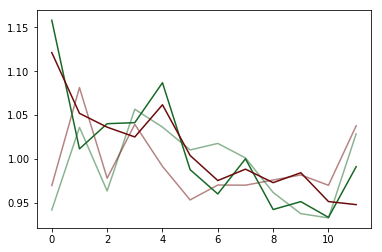

In [15]:
model = makeGridModel(12)
radialDist(model, 12, True)
print(model.countCooperatorRatio())
model.runSim(2000)
radialDist(model, 12, False)
print(model.countCooperatorRatio())


In [14]:
defectorUtility = -0.21 
 
politicalClimate=0.2 #Being environment-positive 

    
#(results) = batch_simulate(12, 1000,100)

#for i in results:
    #plt.plot(i)

c:\users\sigrid\appdata\local\programs\python\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
c:\users\sigrid\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Defectors: avg:  0.5191666666666667  std:  0.23506624985355123
Cooperators: avg:  0.5175  std:  0.28436235445650876


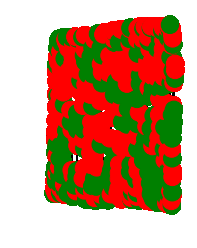

<Figure size 864x648 with 0 Axes>

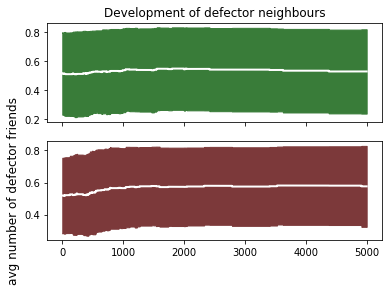

In [114]:
(model, ratio) = simulate(12, 1000, drawModel= False, countNeighbours= False)


{1, 2, 3}
{2, 3}


0.41
Defectors: avg:  0.7372881355932204  std:  0.2728159348725995
Cooperators: avg:  0.3882113821138211  std:  0.312144106286553


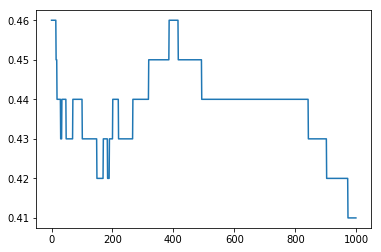

In [40]:
plt.plot(ratio)
print(model.countCooperatorRatio())
(defectorDefectingNeighs, cooperatorDefectingFriends, defectorDefectingNeighsSTD, cooperatorDefectingFriendsSTD)=model.getAvgNumberOfDefectorNeigh()
print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
        

[1, 12]


ZeroDivisionError: division by zero